$
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
$

# Neural Networks - Regression #2 (Workbook)

### ITCS 4156
### Minwoo "Jake" Lee

# Goal

The goal of this activity is to implement and understand the neural network class provided in the class note. We'll also start seeing what it is like applying the chain rule for $n$ hidden layers. Once again, we will be working with [tree root biomass data](https://figshare.com/articles/_The_Allometry_of_Coarse_Root_Biomass_Log_Transformed_Linear_Regression_or_Nonlinear_Regression_/817238) as we used last week. 

Follow the TODO titles and comments to finish the activity! 

# Agenda

1. Data Loading, Preprocessing, and Visualization (copy of last week's lab)
    * Downloading, Loading, and Preprocessing
    * Data Visualization
    * Data Partitioning
* Apply Nonlinear Regression: Neural Network Class
    * Variables
    * Forward Pass Steps
    * Backward Pass Equations

In [1]:
from copy import deepcopy as copy
from IPython.core.debugger import set_trace

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Data Loading, Preprocessing, and Visualization

So why use tree root biomass data? Better yet, what even is tree root biomass? Root biomass is a fancy way of referring to the weight of a root. It turns out that root biomass is a good way to measure the potential accumulated carbon in a tree's roots. Thus, if we want to predict the potential accumulated carbon in a tree's root system then we need to predict the tree's root biomass. This indirect prediction of accumulated carbon via predicting root biomass is called allometry.

So once again, why use root biomass data? It turns out that digging up every tree in a forest and measuring every trees' roots biomass might be implausible and counterproductive. It also turns out prior work on this issue has shown that there seems to be a linear correlation between root biomass and the root diameter (DBH). Even more recent work seems to indicate that predicting biomass based on root diameter might even have a nonlinear correlation. This sounds like a pretty good dataset to test the differences of linear regression and our newly learned method of nonlinear-regression.

Knowing this, we want to apply linear and nonlinear regression to predict tree root biomass: given two parameters: type of tree and root diameter.

Below is an brief excerpt from the description of the tree root biomass dataset.
> Precise estimation of root biomass is important for understanding carbon stocks and dynamics in forests. Traditionally, biomass estimates are based on allometric scaling relationships between stem diameter and coarse root biomass calculated using linear regression (LR) on log-transformed data. Recently, it has been suggested that nonlinear regression (NLR) is a preferable fitting method for scaling relationships. But while this claim has been contested on both theoretical and empirical grounds, and statistical methods have been developed to aid in choosing between the two methods in particular cases, few studies have examined the ramifications of erroneously applying NLR

## Downloading, Loading, and Preprocessing

You can download the allometry of tree root biomass data using the following link [here](https://figshare.com/articles/_The_Allometry_of_Coarse_Root_Biomass_Log_Transformed_Linear_Regression_or_Nonlinear_Regression_/817238). Once you have downloaded the data you will need to unzip the dataset and store the datafile `Appendix_S1.csv` in the same folder as this notebook! 

Okay, the first step is to load our tree root biomass data into a **Pandas DataFrame object**. 

In [3]:
tree_biomass_file = 'Appendix_S1.csv'
tree_df = pd.read_csv(tree_biomass_file)
tree_df

,sp,dbh,rootbiomass
0,Castanopsis eyrei,1.08,0.16
1,Castanopsis eyrei,1.85,0.15
2,Castanopsis eyrei,2.46,0.46
3,Castanopsis eyrei,2.60,1.08
4,Castanopsis eyrei,4.46,1.34
...,...,...,...
154,Schima superba,32.92,253.57
155,Schima superba,34.00,122.55
156,Schima superba,37.20,136.30
157,Schima superba,38.00,181.13


Remember, our tree type features are strings and must be converted to indicator variables in order to be utilized by our neural network class. 

Here, we covert our tree type strings, column 'sp', to indicator variables and automatically insert them back into our data using Panads `pd.get_dummies()` method. We also add the prefix parameter that appends 'sp' to the beginning of each tree type name. For example, we change the tree type names from `Castanopsis eyrei`, 'Pinus massoniana' and, 'Schima superba' to 'sp_Castanopsis eyrei', 'sp_Pinus massoniana', and 'sp_Schima superba'. Lastly, we reorganize the columns so that tree types occupy the first three columns.

In [4]:
# ?pd.get_dummies

In [5]:
X = pd.get_dummies(tree_df.iloc[:, :-1], prefix='sp').copy()
X = X[['sp_Castanopsis eyrei', 'sp_Pinus massoniana', 'sp_Schima superba', 'dbh']]
X

,sp_Castanopsis eyrei,sp_Pinus massoniana,sp_Schima superba,dbh
0,1,0,0,1.08
1,1,0,0,1.85
2,1,0,0,2.46
3,1,0,0,2.60
4,1,0,0,4.46
...,...,...,...,...
154,0,0,1,32.92
155,0,0,1,34.00
156,0,0,1,37.20
157,0,0,1,38.00


Next, let's extract the target column 'rootbiomass' which corresponds to tree root biomass.  The below code simply access the 'rootbiomass' column and copies it into the variable `T`. Note, that we add double squared brackets `tree_df[['rootbiomass']].copy` so that when we call `T.values` a Numpy array with two dimensions, i.e. (158, 1), will be returned. Otherwise, if we only add single brackets `tree_df['rootbiomass'].copy` then when we call `T.values` a Numpy array with one dimension, i.e (158,), will be returned. **Remember always, ALWAYS, be thinking about your data shapes.**

In [6]:
T = tree_df[['rootbiomass']].copy()  # need extra square brackets not to lose 2d shape (or dataframe)
T

,rootbiomass
0,0.16
1,0.15
2,0.46
3,1.08
4,1.34
...,...
154,253.57
155,122.55
156,136.30
157,181.13


## Data Visualization

To start let's take a look at how our feature root diameter 'dbh' and our target root biomass 'rootbiomass' might correlate to one-another. There is a cool Pandas plotting function called `scatter_matrix` that let's us quickly plot features against each other (this is similar to what we did back in our first lab on data visualization). In addition, on the main diagonal instead of plotting the identical features against each other it plots the distribution of the data.

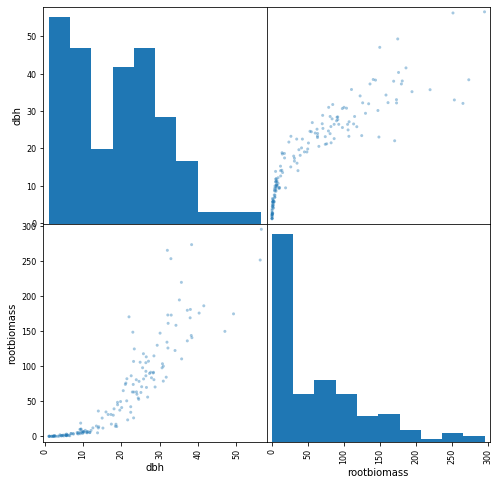

In [7]:
from pandas.plotting import scatter_matrix

scatter_matrix(tree_df, alpha=0.4, figsize=(8,8));

Unlike most correlation plots the main diagonal for our `scatter_matrix()` function is not a given feature plotted against itself. Instead, the `scatter_matrix()` function produces a more useful plot, the data distribution of a given feature. Last week, we saw a smoothed version of the above main diagonal plots - remember we had line graphs last week. This week, we can visualize the same smoothed line graphs but now as histograms. If you want the smoothed line graph back simply add the parameter `diagonal='kde'` to the `scatter_matrix()` function.

Let's look at 'dbh' (root diameter) on the main diagonal, i.e. the first subplot. On the x-axis we can see the range of 'dbh' values contained in our dataset. Meanwhile, on the y-axis we can see the number of samples in our data that have a given root diameter value. For example, there are approximately 45 samples of roots with diameters around 10 and 30. 

On the off-diagonal we can see the plots for features plotted against each other (each side of the off-diagonal is essentially a reflection of the other side). Here we can look for correlations between features just like normal correlation plots.

Next, let's plot the same scatter matrix but this time let's add in tree types. To do so, we simply combine our `X` and `T` DataFrames, defined above, and then pass this concatenation to the `scatter_matrix()` function. Remember, `X` contains our tree type indicator variables and root diameter features while `T` contains root biomass.

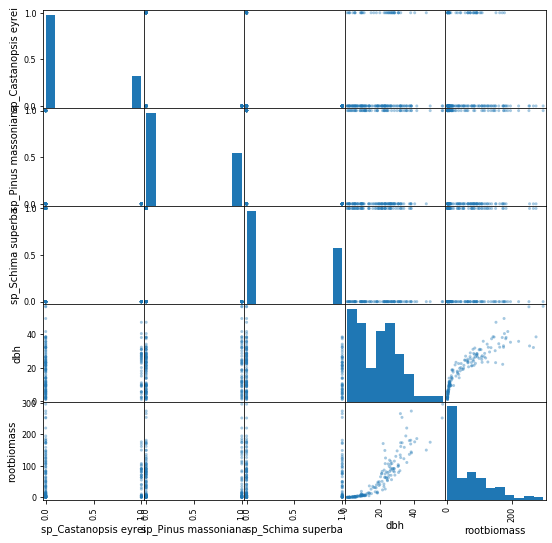

In [8]:
Data = pd.concat([X, T], axis=1)
scatter_matrix(Data, alpha=0.4, figsize=(9,9));

We can see our original plot is in the bottom right-hand corner. As stated before, the main diagonal represents data distribution for each feature. Meanwhile, on the off-diagonal we can see the plots for features plotted against each other. 

We can see that when the tree type variables are plotted against each other there are only three plotted points. For example, check out when 'Castanopsis eyrei' is plotted against 'Pinus massoniana'. We can see on the y-axis the point plotted at (0, 1) is for 'Castanopsis eyrei' and on the x-axis we can see the point plotted at (1, 0) is for 'Pinus massoniana'. At (0, 0) we can see the "other" tree types that aren't 'Castanopsis eyrei' or 'Pinus massoniana' (in this case, this is only the tree type 'Schima superba').

However, when looking at each tree type plotted against ‘dbh’ or ‘rootbiomass’ we can see the spread of each trees' root diameter or biomass values. Take the bottom left plot for example. Here 'Castanopsis eyrei' is plotted against 'rootbiomass'. Looking at the x-axis we can see 0 indicates all other tree types, while 1 indicates 'Castanopsis eyrei'. Now, looking at the y-axis we can see the spread of the root diameter values. It seems  'Castanopsis eyrei' root diameter values seem to be concentrated under 200!

### Taking a Closer Look at Root Diameter and Biomass Spread

Let's now take a closer look at how the root diameter and biomass spread changes per tree type, as we noticed in the scatter matrix plots. Let's simply create two line graphs using Pandas `.plot()` method. One plot will be for our training features `X` and the other plot will be for our target `T`.

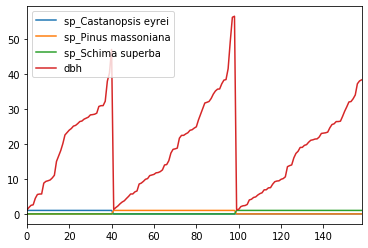

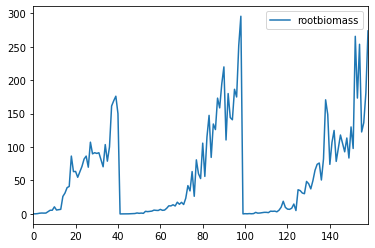

In [9]:
X.plot()
T.plot()

Welp, it is kinda hard to tell which root diameter and biomass values are associated with each tree type. However, we can decipher a change in the class when we see 'dbh' and 'rootbiomas' values suddenly drop extremely low. For example, we could argue the separation between our classes occurs around the 40th and 100th data samples. However, this is only because our data is ordered by tree types. Meaning, the 'sp_Castanopsis eyrei' trees are the first 40ish samples while the 'sp_Pinus massoniana' trees are the next 60ish samples.

There must be a better way to plot our data. Indeed there is! To do so we can first plot our original DataFrame `tree_df` to plot all our features, including our target. Then we can use our tree type indicator variables called `tree_type_dummies` to color in areas of the graph that correspond to each tree. We can using the Pandas DataFrame `plot()` method to plot our `tree_df` and the `plot.area()` method to color in our graph. The last thing we need to do is scale the values of `tree_type_dummies` to fill in the entire graph up to the potential max y-values. (Remember `tree_type_dummies` only contains 1s and 0s so by default the `plot.area()` would only fill from 0 to 1!)

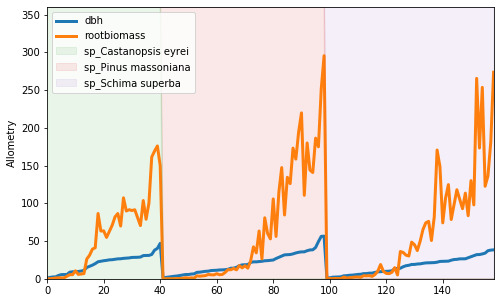

In [10]:
scale_y_axis = 1.2 # y-axis scale
tree_type_dummies = X.iloc[:, :-1]  # Extract and store our tree type indicator varaibles
max_y_value = np.round(np.max(Data.max().values), decimals=-2) * scale_y_axis # Find the max y-value and scale it

ax = tree_df.plot(linewidth=3, figsize=(8,5)) # plots all features 
(tree_type_dummies * max_y_value).plot.area(ax=ax, alpha=0.1) # colors in graph
plt.ylim([0, max_y_value]) # sets the y-axis min and max values
plt.ylabel("Allometry"); # the ';' here surpresses output

There we go! Now we can get a much better visualization of each trees' root diameter and root biomass values. In addition, we can see how these values compare to one another!

## Data Partitioning
Like always we need to split our data into train and test partitions.

The below code is the `partition()` function we used last week. Recall, that the `partition()` function takes as input the following **Numpy arrays** `X` and `T`. The output of  `partition()` is a list of data and targets where `Xs` holds our training and testing data partitions and `Ts` holds our training and testing target partitions. The elements of `Xs` and `Ts` are Numpy arrays. 


### Saving code cells to files
As we'll be repeatedly using the `partition()` function in the future, let's write it to a `.py` file. We can easily do so using one of Jupyter's built-in Magic commands called `writefile`. The `writefile` Magic writes the contents of the cell to a specified file path. For example, to save the partition code cell below to the file 'partitionlib.py' we add the following line at the top of the code cell `%%writefile partitionlib.py`. When we run the cell, then the code is saved to our specified 'partitionlib.py' file path.

To check out the `writefile` Magic and others see the documentation [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html).

In [11]:
%%writefile partitionlib.py

import numpy as np

# now partition the data 

""" partitioning data

    parameters
    -----------
    X        numpy array
             input data to partition
    T        numpy array
             target labels to partition
    raito    list
             list of ratios for partitions (should be summed to 1) 
             the number of return pairs are different
    return
    -------
    
    Xs       list of numpy arrays
    
    Ts       list of numpy arrays
"""
def partition(X, T, ratio=[0.8, 0.2]): 
    
    # Checks to make sure ratio sums to 1
    assert(np.sum(ratio) == 1)
    
    # Store the number of data samples 
    N = X.shape[0]

    # change the 1d array to 2d if need
    if len(T.shape) == 1:
        T = T.reshape((N,1))
    
    # Shuffle the data indices 
    idxs = np.random.permutation(N)
        
    Xs = []
    Ts = []
    i = 0  # first index to zero
    for k, r in enumerate(ratio):
         # Number of rows that corresponds to kth element in ratios
        nrows = int(round(N * r)) 
        
        # print (i, nrows)
        # If we are on the last ratio simply use the remaining data samples
        if k == len(ratio)-1:
            Xs.append(X[idxs[i:], :])
            Ts.append(T[idxs[i:], :])
        else:
            Xs.append(X[idxs[i:i+nrows], :])
            Ts.append(T[idxs[i:i+nrows], :])
        
        i += nrows
    
    return Xs, Ts

Overwriting partitionlib.py


Linux and Mac users can check the content of 'partitionlib.py' file we just saved by uncommenting the shell command below (this will thrown errors if ran by Windows users). For Window users, feel free to open 'partitionlib.py' in a text editor to see what exactly was saved. Note, the 'partitionlib.py' file should be saved to the same directory as this notebook!

In [11]:
# !cat partitionlib.py 


import numpy as np

# now partition the data 

""" partitioning data

    parameters
    -----------
    X        numpy array
             input data to partition
    T        numpy array
             target labels to partition
    raito    list
             list of ratios for partitions (should be summed to 1) 
             the number of return pairs are different
    return
    -------
    
    Xs       list of numpy arrays
    
    Ts       list of numpy arrays
"""
def partition(X, T, ratio=[0.8, 0.2]): 
    
    # Checks to make sure ratio sums to 1
    assert(np.sum(ratio) == 1)
    
    # Store the number of data samples 
    N = X.shape[0]

    # change the 1d array to 2d if need
    if len(T.shape) == 1:
        T = T.reshape((N,1))
    
    # Shuffle the data indices 
    idxs = np.random.permutation(N)
        
    Xs = []
    Ts = []
    i = 0  # first index to zero
    for k, r in enumerate(ratio):
         # Number of rows that corresponds to kth element in ratios
       

### Importing your own python files

Now we can import our saved 'partitionlib.py' by using the typical Python import format. However, now we are referring to our saved file 'partitionlib' instead of a pip or conda installed module (package).

In [12]:
import partitionlib as ptl

Here we are referencing the local file 'partitionlib.py' by saying `import partitionlib` (note, we do not need to add '.py'). Next, we can nickname the import to 'ptl' using `as ptl`. Nicknaming simply allows us to reduce the length of long package or file names.

Now, we can refer to our `partition()` function with the following line `ptl.partition`. Recall, the nickname `plt` is referring to the file we imported and `partition()` is a function within the nicknamed file `plt`.

In [13]:
ptl.partition

<function partitionlib.partition(X, T, ratio=[0.8, 0.2])>

You may come to notice that if we add code to our 'partitionlib.py' file after running the above import `import partitionlib as ptl` the newly added code will not be reflected in our function when ran. The issue here is that when we import our 'partitionlib.py' file Python takes a static snapshot of the code in 'partitionlib.py'. As you might have guessed, this means that even when we update the 'partitionlib.py' file with new code, Jupyter will not know about any of the changes (as it will be using an old "snapshot").

For example, let's say we ran our import `import partitionlib as ptl` within Jupyter, but then decided we wanted to add the following line `print("Running partition")` to our `partition()` function in the 'partitionlib.py' file.  However, now when we go to run the `partition()` function within Jupyter our changes made in the  'partitionlib.py' file **will not** be reflected. Let's look at how we can overcome this issue.


### Updating imports by the restarting kernel
The easiest way to overcome this issue and update our snapshot is by restarting the notebook's kernel. To restart the kernel go to the main menu bar at the top of the notebook and select 'Kernel' -> 'Restart' (restarting the kernel will require us to rerun all our cells). Once the kernel has been restarted then we can rerun `import partitionlib as ptl` which will now have our updated file. Simply rerunning the code cell containing `import partitionlib as ptl` will not update our snapshot, we must restart the kernel.

### Updating imports using manual reload
While restarting the kernel is relatively straight forward it can be quite costly to restart our notebook every time we make a change to our 'partitionlib.py' file. One way to get around this is to use the built-in Python module `importlib` and its `reload()` method. By calling the method `importlib.reload(partitionlib)` this tells our notebook to manually update our import snapshot to reflect our new code, without needing to restart the kernel. 

**Now, instead of restarting the kernel we only have to rerun `importlib.reload(partitionlib)` every time we make changes to the 'partitionlib.py' file**.

In [14]:
# ?importlib.reload

In [15]:
import importlib
import partitionlib
importlib.reload(partitionlib)

<module 'partitionlib' from '/home/dev/workspace/4156/in-class-activity/nonlinear-regression-2/partitionlib.py'>

### Updating imports automatically

Well, even running `importlib.reload` every time we change code in our 'partitionlib.py' file can be annoying. Luckily, there is a neat Magic that can automatically reload our imports before executing code. Sadly, this method isn't fault proof and can sometimes fail given certain caveats (see documentation below). This autoloading Magic is called `autoreload`. It can be loaded using `%load_ext autoreload` and then activated using `%autoreload`. There are a few parameters that can be pass to `%autoreload` which change how the automatically reloading works (see documentation below). For now, we will simply add `%autoreload 2` which will reload all modules every time before executing our Python code.

For more information on `autoreload` and its caveats check out the following documentation [here](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html).

In [16]:
# just in case, you made change in the file, you may need to reload as blow
%load_ext autoreload
%autoreload 2

### TODO: 
Here we have modified the `partition_data()` function to return our partitions. This is done in order to rid ourselves of the pesky global variables we had before. 

Notice, we pass Numpy arrays to our partition function using `X.values` and `T.values`. Thus, we can expect Numpy arrays to be stored within the lists `Xs` and `Ts`.

1. Split the `data` output from the `partition()` function into `Xtrain`, and `Xtest`
2. Split the `targets` output from the `partition()` function into `Ttrain`, and `Ttest`
3. Return the partitioned data in the following order: `Xtrain`, `Xtest`, `Ttrain`, `Ttest`

In [17]:
# Let us modify previous partition_data function not to use global variables

def partition_data(X, T):
    """Partition data into train and test splits."""
    data, targets = ptl.partition(copy(X.values), copy(T.values))
    # TODO (1)
    Xtrain, Xtest = data
    # TODO (2)
    Ttrain, Ttest = targets
    
    # TODO (3):
    return Xtrain, Xtest, Ttrain, Ttest

In [18]:
Xtrain, Xtest, Ttrain, Ttest = partition_data(X, T)
print("Train data shape: {}".format(Xtrain.shape))
print("Train target shape: {}".format(Ttrain.shape))
print("Test data shape: {}".format(Xtest.shape))
print("Test target shape: {}".format(Ttest.shape))

Train data shape: (127, 4)
Train target shape: (127, 1)
Test data shape: (32, 4)
Test target shape: (32, 1)


 Before we end this section let's define some variables that'll be used later on. Here we set `N` to store the total number of data samples and `D` to store the total number of features. Likewise, we set `Ntrain` to store the total number of training data samples and `Ntest` to store the total number of testing data samples.

In [19]:
N = X.shape[0] # Number of data samples
D = X.shape[1] # Number of data features
K = T.shape[1] # Number of output values
Ntrain = Xtrain.shape[0] # Number of train data samples
Ntest = Xtest.shape[0] # Number of test data samples
print("N = {} data samples".format(N))
print("D = {} data features".format(D))
print("K = {} data features".format(K))
print("Ntrain = {} training data samples".format(Ntrain))
print("Ntest = {} testing data samples".format(Ntest))

N = 159 data samples
D = 4 data features
K = 1 data features
Ntrain = 127 training data samples
Ntest = 32 testing data samples


# Apply Nonlinear Regression: Neural Network Class

Finally, it is time for us to reimplement our Neural Network from last week, but this time structured as a class. We have left last week's summary below in-case you need a reference for how the forward and backward passes work. 

**Remember that we randomly partitioned our data and randomly initialized our weights, which means that your plots and RMSE might vary from ours!**

## Variables 

Here is a list of the variables,  shapes, and their description.

- $X : N \times D$ - Input Data without bias
    - $N$ is the number of data samples
    - $D$ is the number of features
- $X1 : N \times (D+1)$ - Input data with bias
    - $(D+1)$ is the number of features plus bias
- $V : (D+1) \times G$ - Input weights
    - Note: $G$ is the number of hidden units
- $Z : N \times G$ - First layer output
    - Note: Activation function is applied here
- $Z1 : N \times (G+1)$ - First layer output with bias
    - $(G+1)$ is the number of hidden units plus bias
- $W : (G+1) \times K$ - Output weights
    - $K$ is the number of outputs (for regression this is 1 and for classification this your number of classes)
- $Y : N \times K$ - Predictions
- $T : N \times K$ - Targets

## Forward Pass Steps

Recall the following steps for making a prediction, also called the forward pass, from the class notes.

1. Calculate first layer output by taking the dot product between the inputs $X1$ and input weights $V$. Then apply the activation function $\tanh$. 
$$Z = \tanh(X1 \cdot V)$$
2. Add bias to $Z$ to get $Z1$
3. Make your predictions by taking the dot product between the output of the first layer $Z1$ and the output weights $W$.
$$Y = Z1 \cdot W$$

## Backward Pass Equations

Recall the backward pass weight updates for $V$ and $W$ from the class notes.

$$ V \leftarrow V + \frac{\rho_v}{N*K}*{X1}^T \cdot ( (T - Y) \cdot W^T \odot (1 - Z^2) )$$

Here $N$ and $K$ are scalars and $\rho_v$ is our learning rate for our input weights $V$. In addition, $X1$ is our input data with bias added, $T$ is our target, $Y$ is our predictions, $W$ is the output weights, and $Z$ is the output of the first layer with the activation function applied. **Recall, that we remove the bias from $W$ for this update as we only take into account the bias for the current weight we are updating! (In the case, since we updating $V$, we only care about the bias for input weight $V$.)**

$$ W \leftarrow W + \frac{\rho_w}{N*K}*{Z1}^T \cdot (T - Y)$$

Here $N$ and $K$ are scalars and $\rho_w$ is our learning rate for our output weights $W$. In addition, $T$ is our target, $Y$ is our predictions, $Z1$ is the output of the first layer with the activation function applied and bias added. 

**Note that $\cdot$ refers to the dot product, $\odot$ refers to the element-wise multiplication, and $*$ refers to scalar multiplication.**

## Standardizer Class

First, let's create a class which will standardize our data called `Standardizer`. Recall that standardization sets all our features to have a mean of 0 and STD of 1, thus equalizing the scales of all our features. If our features are operating under different scales our gradient updates and weights can be biased towards features with larger scales. 

### TODO

Recall, the formula for standardizing is as follows.

$$\frac{X - mean(X)}{STD(X)}$$

1. Finish the `standardize()` method below by standardizing the passed data `X` using the standardization formula above. Here `self._mu` is our mean, and `self._sigma` is our STD. Be sure to return the newly standardized data!

In [20]:
# standardization class
class Standardizer: 
    """ class version of standardization """
    def __init__(self, X, explore=False):
        self._mu = np.mean(X,0)  
        self._sigma = np.std(X,0)
        if explore:
            print ("mean: ", self._mu)
            print ("sigma: ", self._sigma)
            print ("min: ", np.min(X,0))
            print ("max: ", np.max(X,0))

    def set_sigma(self, s):
        """ Set STD """
        self._sigma[:] = s

    def standardize(self, X):
        """ Convert passed data to have a mean of 0 and STD of 1"""
        # TODO (1)
        return (X - self._mu) / self._sigma 

    def unstandardize(self, X):
        """ Convert standardized data back to its orignal scale """
        return (X * self._sigma) + self._mu 
    

## Neural Network Class

The below neural network code is copied from the class notes, feel free to reference them ([class notes link](https://nbviewer.jupyter.org/url/webpages.uncc.edu/mlee173/teach/itcs4156/notebooks/notes/Note-Neural%20Networks.Sol.ipynb)). If you have not downloaded the 'grad.py' file yet, please do by using the following link: [gray.py link](https://webpages.uncc.edu/mlee173/teach/itcs4156/notebooks/notes/grad.py). To download, right-click on the 'grad.py' code and select "Save Page As". Be sure to save the 'grad.py' file in the same directory as this notebook!

If you're on Linux or Mac, you can uncomment and run the following cell below to download the 'grad.py' file to your current directory (if you're on Windows the below code cell might throw an error).

In [21]:
# !curl -o grad.py https://webpages.uncc.edu/mlee173/teach/itcs4156/notebooks/notes/grad.py

### forward() method
The `forward()` method works much like the forward pass code from from last week, except now we can have more than one hidden layer. Thus, we create a loop that will loop through each layer where we add bias, compute the linear output, and then apply the activation function. Here `t` acts as the output for each layer and `Z` stores the input of each layer. `t` is acting like our $Z$ and $Z1$ from last week (don't be fooled by the programming notation used). `Z` in our loop is simply tracking the input for each layer, which is the output from the previous layer (acts as a history of `t`). For example, the output of the first hidden layer would be the input for the second hidden layer.

### backward() method

Recall the $W$ and $V$ updates from last week below. Remember when performing the chain rule, i.e. the backwards pass, we start by updating the output weights first. We then continue updating each layers weights until we reach the input layer. In last weeks example we only had one hidden layer. Thus, we only had input and output weights so our equations were simply $W$ and $V$.

$$ W \leftarrow W + \frac{\rho_w}{N*K}*{Z1}^T \cdot (T - Y)$$

$$ V \leftarrow V + \frac{\rho_v}{N*K}*{X1}^T \cdot ( (T - Y) \cdot W^T \odot (1 - Z^2) )$$

Now that we can have $n$ hidden layers we need to apply the chain rule formula. In essence, our $V$ is now $V_n$ where we must update the weights for each $n$th hidden layer. To do so we need to propagate the gradient from the output layer all the way to the input layer.

Let's look at the below line of code from the `backward()` method. Here we can start to see how our code for the chain rule will account for both the $W$ update and the $V$ update for $n$ hidden layers.

`dws.insert(0,(-rh * (self.add_ones(Z[layer]).T @ delta) + lmbterm))`

Here `delta` will act as the gradient from the previous layer or the output error and `self.add_ones(Z[layer])` acts as the current layer's input with bias added, in other words, the output from the previous layer with bias added. This line of code might look familiar to you if you ignore `lmbterm` (`lmbterm` is a regularization term that is not important to us at the moment). For the first iteration of the loop, the above line is exactly like our $W$ weight update equation. This makes sense because we start from the output and $W$ was our output weight update. The following loop iterations for this line of code will look like our equation for $V$, where `delta`acts as $(T - Y) \cdot W^T \odot (1 - Z^2)$. However, what used to be our output error for $(T - Y)$ for $W$ now becomes our propagated gradient for the remaining loop iterations!


### TODO:

Reference the class note if you get stuck as example code is implemented there!

**Forward pass**
1.  Add code for the **output** layer computation (dot product). To do so add ones to `t` and then compute the dot product between `t` and the weights for the current layer. Store the output back into `t`.
    1. Hint: `t` is the output from the previous layer. `self._W` is a list of arrays where each array corresponds to a given layer's weights. Thus, be sure to index `self._W` according to the for loop iterator `layer` to get the current layer's weights!
<br><br>
2. Add code for the **input and hidden layer** computation (i.e. activation applied to linear model output). To do so add ones to `t` and then compute the dot product between `t` and the current layer's weights. Lastly, apply the `np.tanh()` activation function to the linear model output. Store the final output back into `t`.
    1. Hint: See TODO (1) hint.

**Backward pass**
3. Add code for the chain rule to propagate the gradient. In other words, implement `delta` using part of the $V$ equation we discussed earlier $(T - Y) \cdot W^T \odot (1 - Z^2)$. Here `delta` corresponds to $(T - Y)$ , $W$ corresponds to `self._W` indexed at the current layer, $Z$ corresponds to `Z` indexed at the current layer. Store the output back into `delta`.
    1. Hint: Recall that we must remove the bias from `self._W`, just like we did last week when updating $V$! 

In [30]:

""" Neural Network 
        referenced NN code by Chuck Anderson in R and C++ 

                                by Jake Lee (lemin)

    example usage:
        X = numpy.array([0,0,1,0,0,1,1,1]).reshape(4,2)
        T = numpy.array([0,1,1,0,1,0,0,1]).reshape(4,2)

        nn = nnet.NeuralNet([2,3,2])
        nn.train(X,T, wprecision=1e-20, fprecision=1e-2)
        Y = nn.use(X)

"""
from grad import scg, steepest
from copy import copy


class NeuralNet:
    """ neural network class for regression
        
        Parameters
        ----------
        nunits: list
            the number of inputs, hidden units, and outputs

        Methods
        -------
        set_hunit    
            update/initiate weights

        pack 
            pack multiple weights of each layer into one vector

        forward
            forward processing of neural network

        backward
            back-propagation of neural network

        train
            train the neural network

        use
            appply the trained network for prediction

        Attributes
        ----------
        _nLayers
            the number of hidden unit layers 

        rho
            learning rate

        _W
            weights
        _weights
            weights in one dimension (_W is referencing _weight)

        stdX
            standardization class for data
        stdT
            standardization class for target

        Notes
        -----
        
    """

    def __init__(self, nunits):

        self._nLayers=len(nunits)-1
        self.rho = [1] * self._nLayers
        self._W = []
        wdims = []
        lenweights = 0
        for i in range(self._nLayers):
            nwr = nunits[i] + 1
            nwc = nunits[i+1]
            wdims.append((nwr, nwc))
            lenweights = lenweights + nwr * nwc
        
        self._weights = np.random.uniform(-0.1,0.1, lenweights) # Initialize weights randomly
        start = 0  # fixed index error 20110107
        for i in range(self._nLayers):
            end = start + wdims[i][0] * wdims[i][1] 
            self._W.append(self._weights[start:end])
            self._W[i].resize(wdims[i])
            start = end
        
        self.stdX = None
        self.stdT = None
        self.stdTarget = True

    def add_ones(self, w):
        """ Add bias to passed weights and then return """
        return np.hstack((np.ones((w.shape[0], 1)), w))

    def get_nlayers(self):
        """ Return of layers """
        return self._nLayers

    def set_hunit(self, w):
        """ Set hidden unit weights """
        for i in range(self._nLayers-1):
            if w[i].shape != self._W[i].shape:
                print("set_hunit: shapes do not match!")
                break
            else:
                self._W[i][:] = w[i][:]

    def pack(self, w):
        """ Return a passed weights stacked """
        # Map applies a given function (np.ravel) to every
        # element in a given iterable (w). We then cast the out of map
        # as a list so the weights can be stacked into a numpy array.
        return np.hstack(list(map(np.ravel, w)))

    def unpack(self, weights):
        """ Update class weights with passed weights """
        self._weights[:] = weights[:]  # unpack

    def cp_weight(self):
        """ Return a copy of the class weights """
        return copy(self._weights)

    def RBF(self, X, m=None,s=None):
        if m is None: m = np.mean(X)
        if s is None: s = 2 #np.std(X)
        r = 1. / (np.sqrt(2*np.pi)* s)  
        return r * np.exp(-(X - m) ** 2 / (2 * s ** 2))

    def forward(self,X):
        """ Forward pass of the neural network
        
            returns
            -------
            
            Retuns output after passing through all layers (t) and
            a list of the inputs for each layer (Z).
        
        """
        t = X # t acts as the output for each layer
        Z = [] # Z stores the input of each layer (i.e. output of previous layer)

        # Loops through each layer in the neural network
        for layer in range(self._nLayers):
            Z.append(t) # Store the input for this layer
            
            # Check if the layer we are on is the last layer.
            # If so, then don't apply the activation function.
            if layer == self._nLayers - 1:
                # TODO (1): fill in for the last layer computation (dot product)
                t = self.add_ones(t) @  self._W[layer]
            else:
                # TODO (2): fill in for the hidden layer computation (activation on linear model output)     
                t = np.tanh(self.add_ones(t) @ self._W[layer])
        return (t, Z)
        
    def backward(self, error, Z, T, lmb=0):
        """ Applies backwards pass to update all hidden layer weights """
        delta = error # Gradient from prvious layer, initialized to the error (T - Y)
        N = T.size # Targets
        dws = []
        # Loop backwards through the layers starting from the output
        for layer in range(self._nLayers - 1, -1, -1):
            rh = float(self.rho[layer]) / N # Learning rate for current layer
            if layer == 0:
                lmbterm = 0
            else:
                # Create a vector for regularization term
                lmbterm = lmb * np.vstack((np.zeros((1, self._W[layer].shape[1])),
                            self._W[layer][1:,]))

            dws.insert(0,(-rh * (self.add_ones(Z[layer]).T @ delta) + lmbterm))
            
            # Calculate the gradient if current layer isn't the input layer
            if layer != 0:
                # TODO (3): Try to write a chain rule of gradient here
                delta = (delta @ self._W[layer][1:, :].T) * (1 - Z[layer]**2)
        return self.pack(dws)

    def _errorf(self, T, Y):
        """ Calcuate the error between targets (T) and predictions (Y)"""
        return T - Y
        
    def _objectf(self, T, Y, wpenalty):
        """ Calculate the RMSE for our targets and predications.
            Here wpenalty is our weights with a regularization 
            term applied.
        """
        return 0.5 * np.mean(np.square(T - Y)) + wpenalty

    def train(self, X, T, **params):
    
        verbose = params.pop('verbose', False)
        # Pop training parameters from parameter dictionary
        _lambda = params.pop('Lambda', 0.) # Regularization parameter for loss function
        niter = params.pop('niter', 1000) # Number of epochs/steps
        
        # Pop metric parameters from parameter dictionary
        wprecision = params.pop('wprecision', 1e-10) # Stop training when weight updates don't exceed passed threshold
        fprecision = params.pop('fprecision', 1e-10) # Stop training when error doesn't exceed passed threshold
        wtracep = params.pop('wtracep', False) # Enable tracking of weights per step
        ftracep = params.pop('ftracep', False) # Enable tracking of erros per step

        # Pop type of optimization to use, defaults to scaled conjugate gradient (scg) 
        optim = params.pop('optim', 'scg')
        
        # Standardize parameters 
        if self.stdX == None:
            explore = params.pop('explore', False)
            self.stdX = Standardizer(X, explore)
        Xs = self.stdX.standardize(X)
        if self.stdT == None and self.stdTarget:
            self.stdT = Standardizer(T)
            T = self.stdT.standardize(T)
        
        # Sub-function of train() to be pased to scg or steepest below
        def gradientf(weights):
            self.unpack(weights)
            Y,Z = self.forward(Xs)
            error = self._errorf(T, Y)
            return self.backward(error, Z, T, _lambda)
        
         # Sub-function of train() to be pased to scg or steepest below
        def optimtargetf(weights):
            """ optimization target function : MSE """
            self.unpack(weights) # Save passed weights
            #self._weights[:] = weights[:]  # unpack
            Y,_ = self.forward(Xs) # Apply forward pass
            Wnb=np.array([])
            for i in range(self._nLayers):
                if len(Wnb)==0: Wnb=self._W[i][1:,].reshape(self._W[i].size-self._W[i][0,].size,1)
                else: Wnb = np.vstack((Wnb,self._W[i][1:,].reshape(self._W[i].size-self._W[i][0,].size,1)))
            wpenalty = _lambda * (Wnb.flatten() @ Wnb.flatten())
            return self._objectf(T, Y, wpenalty)
        
        # Select to optimize with scaled conjugate gradient or
        #  with steepest decent.
        if optim == 'scg':
            result = scg(self.cp_weight(), gradientf, optimtargetf,
                        wPrecision=wprecision, fPrecision=fprecision, 
                        nIterations=niter,
                        wtracep=wtracep, ftracep=ftracep,
                        verbose=False)
            self.unpack(result['w'][:]) # Save updated weights
            self.f = result['f'] # Store error computed by scg
        elif optim == 'steepest':
            result = steepest(self.cp_weight(), gradientf, optimtargetf,
                                nIterations=niter,
                                xPrecision=wprecision, fPrecision=fprecision,
                                xtracep=wtracep, ftracep=ftracep )
            self.unpack(result['w'][:]) # Save updated weights
            
        # Check if error tracking is enabled
        if ftracep:
            self.ftrace = result['ftrace']
        if 'reason' in result.keys() and verbose:
            print(result['reason'])

        return result

    def use(self, X, retZ=False):
        # Check if input data need to be standardized
        if self.stdX:
            Xs = self.stdX.standardize(X)
        else:
            Xs = X
            
        # Apply forward pass to get predictions
        Y, Z = self.forward(Xs)
        
        # Check if targets need to be standardized
        if self.stdT is not None:
            Y = self.stdT.unstandardize(Y)
        if retZ:
            return Y, Z
        
        return Y



Our neural network class is now ready. Let's create an instance to fit on the tree root biomass data.

### TODO: 

1. Initialize `nHidden`, the number of hidden units, to 5.
2. Initialize the `NeuralNet` class by passing a list to the parameter 'nunits'. Store output into `nn`.
    1. Hint: The parameter 'nunits' is a list where the first element is the number of inputs you have `D` and the last element is the number of outputs you have `K`. Any elements between our input and output elements are considered hidden layers. For each hidden layer you must specify the number of hidden units each layer will have. For this example, let's use only one hidden layer with `nHidden` hidden units. See class notes linked above for an example of how to initialize the `NeuralNet` class if you are stuck.
3. Next, let's train our `nn` instance using `nn.train()`. Pass our train data `Xtrain`, our test data `Ttrain` and set the parameter 'ftracep' equal to true (this allows us to trace the training error per step).
4. Finally, let's see how well the weights learned our training data for the `nn` instance by using the `nn.use()` method and passing `Xtrain` again. Store output into `Ytrain`.

In [31]:
# TODO (1)
nHidden = 5

# TODO (2)
nn = NeuralNet([D,nHidden,K])

# TODO (3)
nn.train(Xtrain, Ttrain, ftracep=True) 

# TODO (4)
Ytrain = nn.use(Xtrain)

### Observing the learning curve: 
Alright, now lets plot the training errors that the `NeuralNet` class has stored in `ftrace` for every step. 


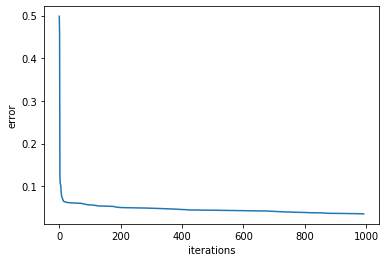

In [24]:
plt.plot(nn.ftrace)
plt.xlabel("iterations")
plt.ylabel("error");

### Plotting results

Now, let's are reusing the `plot_fit()` function from last week and compare our targets `Ttrain` and predications `Ytrain`.

In [25]:
def plot_fit(Y, T, title=None):
    """ Plot the passed predictions and targets while also computing
        and printing the RMSE.
    """
    plt.plot(T, label="target")
    plt.plot(Y, linewidth=3, label="prediction")
    plt.legend()
    plt.ylabel("Allometry")
    plt.xlabel("Samples")
    plt.title(title)
    # RMSE
    rmse = np.sqrt(np.mean((Y - T)**2))
    print("RMSE: {}".format(rmse))

RMSE: 18.003388314143667


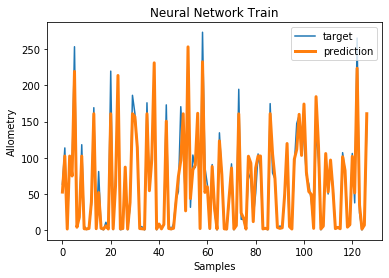

In [26]:
plot_fit(Ytrain, Ttrain, title="Neural Network Train")



### TODO:
Now let's check our test predications and their targets. Take a second to think about how well our test predictions and targets might match-up based on our training results.

1. Test our neural network instance `nn` by passing our testing data `Xtest` to the` nn.use()` method. Store the output into `Ytest`.

RMSE: 23.981751463705862


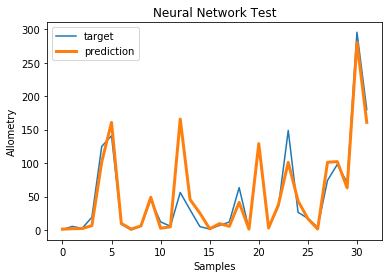

In [27]:
# TODO(1)
Ytest = nn.use(Xtest)

plot_fit(Ytest, Ttest, title="Neural Network Test")

Welp, that's it for any required work for this lab. What do you think about this version? Is it easier to use? Does it work better? Harder to understand? 

If you have extra time or simply want to learn about tuning parameters for neural networks we highly recommend trying out these bonus exercises from last week. These tests will be much easier to complete since we have a neural network class now! 

**Bonus TODOs are not graded!**

### BONUS TODO (1): 
You may not notice a large difference between the models. You might even see that the nonlinear regression algorithm is overfitting.

Try adjusting the number of hidden units by changing the value of `nHidden`, when initializing `NeuralNet`, to 10, 50, and 100. Do you notice any differences in the test RMSE and plot? Does your neural network seem to be overfitting more or less?

### BONUS TODO (2):

Now, let's try stopping a bit earlier. Let's try to stop before our test error increases while training error still decreases, as this is sign of overfitting.

Try decreasing the number of gradient decent steps by adjusting the `niter` variable when running `nn.train()`. Try using 15k, 5k, and 500. Notice any changes in the prediction plots or RMSE? 